In [95]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
transform = transforms.Compose([
	transforms.ToTensor(),
])

In [3]:
def get_data(y_min, y_max):
	train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
	test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

	X_train, y_train = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
	X_test, y_test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))

	X_train = X_train.view(-1, 28*28)
	X_test = X_test.view(-1, 28*28)
	# add a 1 to the end of each sample for the bias term
	X_train = torch.cat((X_train, torch.ones(X_train.shape[0], 1)), dim=1)
	X_test = torch.cat((X_test, torch.ones(X_test.shape[0], 1)), dim=1)

	y_train[y_train < 5] = y_min
	y_train[y_train >= 5] = y_max
	y_test[y_test < 5] = y_min
	y_test[y_test >= 5] = y_max

	return X_train, y_train, X_test, y_test


In [4]:
def logistic_loss(y, x, theta):
	y_pred = x @ theta
	y_pred = y_pred.squeeze()
	loss = torch.log(1 + torch.exp(-y * y_pred)).mean()
	return loss

In [5]:
def non_linear_least_squares_with_sigmoid_loss(y, x, theta):
	y_pred = x @ theta
	y_pred = y_pred.squeeze()
	loss = (y - 1 / (1 + torch.exp(-y * y_pred))).mean()
	return loss

In [6]:
@torch.no_grad()
def line_search(f, x, w, y, loss, s, beta=0.5, c=1e-4, max_iter=16):
	alpha = 1
	n_iter = 0
	loss = loss.item()
	while f(y, x, w + alpha * s) >= loss + c * alpha * -(s.T @ s):
		alpha *= beta
		if n_iter >= max_iter:
			break
		n_iter += 1
	return alpha

In [7]:
@torch.no_grad()
def accuracy_func(y, x, theta):
	y_pred = x @ theta
	y_pred = torch.sign(y_pred).squeeze()
	return (y_pred == y).float().mean()

In [8]:
def two_level(X, y, loss_func, p, sample_size, n_epochs, verbose=False):
	theta = torch.randn(X.shape[1], 1, dtype=torch.float32, requires_grad=True)
	X_h = X
	y_h = y
	Losses_h = []
	Losses_H = []
	accuracies = []
	delta_fine_iter = []
	delta_coarse_iter = []
	time_start = time.time()
	for epoch in range(n_epochs):
		theta.grad = None
		loss_h = loss_func(y_h, X_h, theta)

		Losses_h.append(loss_h.item())

		loss_h.backward()
		s = -theta.grad
		alpha = line_search(loss_func, X_h, theta, y_h, loss_h, s)
		with torch.no_grad():
			theta += alpha * s

		loss_after_fine = loss_func(y_h, X_h, theta)
		delta_fine_iter.append(loss_h.item() - loss_after_fine.item())

		idx = np.random.choice(X_h.shape[0], int(X_h.shape[0] * sample_size), replace=False)
		X_H = X_h[idx]
		y_H = y_h[idx]
		theta_H = theta.clone().detach().requires_grad_(True)
		loss_H = loss_func(y_H, X_H, theta_H)
		theta_H.grad = None
		loss_H.backward()
		s_H = -theta_H.grad
		V_H = -s - s_H

		Losses_H.append([])

		for _ in range(p):
			loss_H = loss_func(y_H, X_H, theta_H) + V_H.T @ theta_H

			Losses_H[-1].append(loss_H.item())

			theta_H.grad = None
			loss_H.backward()
			s_H = -theta_H.grad
			alpha = line_search(lambda y, x, w: loss_func(y, x, w) + V_H.T @ w, X_H, theta_H, y_H, loss_H, s_H)
			with torch.no_grad():
				theta_H += alpha * s_H
		s_h = theta_H - theta
		alpha = line_search(loss_func, X_h, theta, y_h, loss_after_fine, s_h)
		with torch.no_grad():
			theta += alpha * s_h
			accuracy = accuracy_func(y_h, X_h, theta)
			accuracies.append(accuracy.item())
		loss_after_coarse = loss_func(y_h, X_h, theta)
		delta_coarse_iter.append(loss_after_fine.item() - loss_after_coarse.item())

		if verbose and epoch % 10 == 0:
			print(f'Epoch {epoch}/{n_epochs}, loss {loss_after_coarse.item()}, accuracy {accuracy.item()}')

	result = {
		'Losses_h': Losses_h,
		'Losses_H': Losses_H,
		'accuracies': accuracies,
		'delta_fine_iter': delta_fine_iter,
		'delta_coarse_iter': delta_coarse_iter,
		'time': time.time() - time_start
	}
	return theta, result

In [9]:
ps = [1, 5, 10]
sample_sizes = [0.1, 0.3, 0.5]
losses = [logistic_loss]

results = {}

for i, loss in enumerate(losses):
	X_train, y_train, X_test, y_test = get_data(-1, 1)
	for p in ps:
		for sample_size in sample_sizes:
			theta, result = two_level(X_train, y_train, loss, p, sample_size, 100)
			train_accuracy = accuracy_func(y_train, X_train, theta).item()
			test_accuracy = accuracy_func(y_test, X_test, theta).item()
			results[f"{p}_{sample_size}"] = result
			print(f"p={p}, sample_size={sample_size}, train_accuracy={train_accuracy}, test_accuracy={test_accuracy}")

p=1, sample_size=0.1, train_accuracy=0.8209333419799805, test_accuracy=0.8273000121116638
p=1, sample_size=0.3, train_accuracy=0.8220499753952026, test_accuracy=0.8266000151634216
p=1, sample_size=0.5, train_accuracy=0.8235499858856201, test_accuracy=0.8296999931335449
p=5, sample_size=0.1, train_accuracy=0.8454333543777466, test_accuracy=0.8446999788284302
p=5, sample_size=0.3, train_accuracy=0.8515833616256714, test_accuracy=0.8600999712944031
p=5, sample_size=0.5, train_accuracy=0.8540666699409485, test_accuracy=0.857699990272522
p=10, sample_size=0.1, train_accuracy=0.8591499924659729, test_accuracy=0.8626999855041504
p=10, sample_size=0.3, train_accuracy=0.860966682434082, test_accuracy=0.8628000020980835
p=10, sample_size=0.5, train_accuracy=0.8619999885559082, test_accuracy=0.8644999861717224


## Train Accuracy

| sample_size |  p=1  |  p=5  |  p=10                                        |
|-------------|-------|-------|---------------------------------------------|
| **0.1**     | 0.821 | 0.845 | 0.859                                       |
| **0.3**     | 0.822 | 0.852 | 0.861                                       |
| **0.5**     | 0.824 | 0.854 | **<span style="color:green">0.862</span>** |

## Test Accuracy

| sample_size |  p=1  |  p=5  |  p=10                                        |
|-------------|-------|-------|---------------------------------------------|
| **0.1**     | 0.827 | 0.845 | 0.863                                       |
| **0.3**     | 0.827 | 0.860 | 0.863                                       |
| **0.5**     | 0.830 | 0.858 | **<span style="color:green">0.864</span>** |


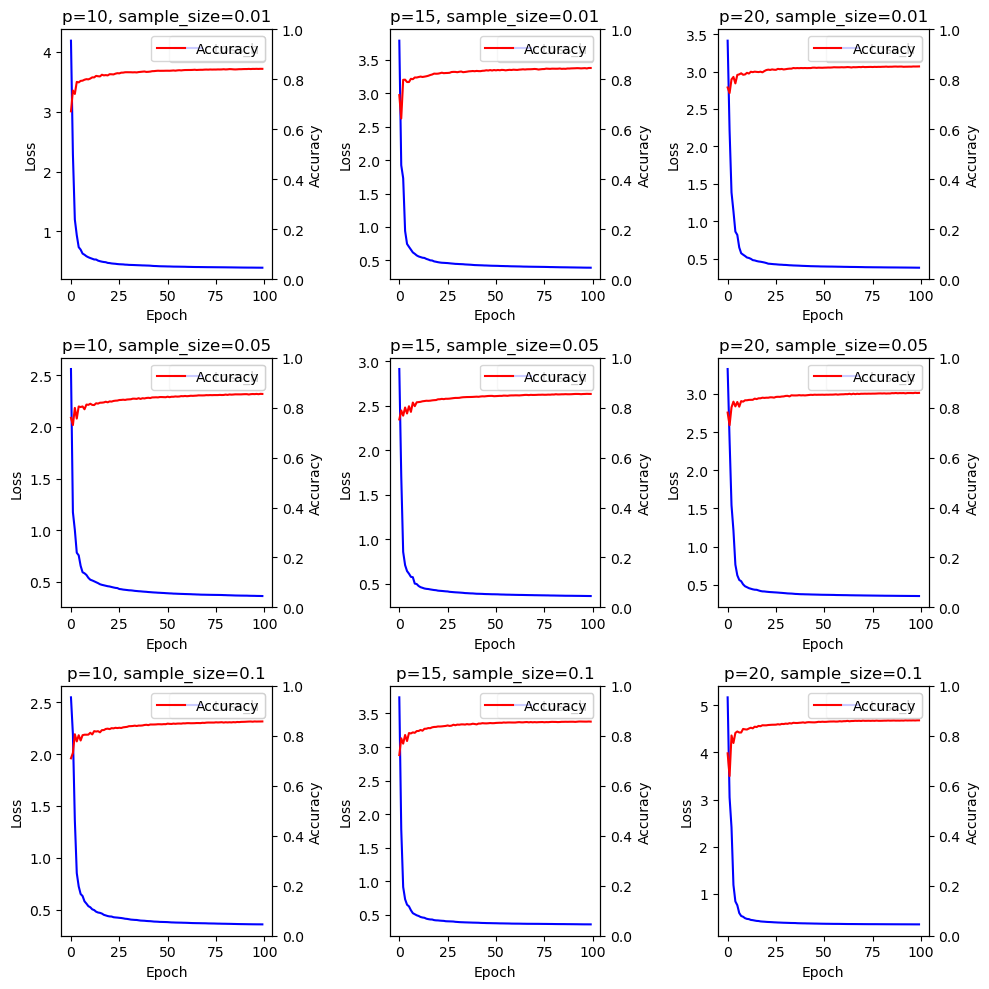

In [36]:
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
		losses_h = results[f"{p}_{sample_size}"]['Losses_h']
		accuracies = results[f"{p}_{sample_size}"]['accuracies']
		ax.plot(losses_h, label="Loss_h", color='blue')
		ax.set_title(f"p={p}, sample_size={sample_size}")
		ax.set_xlabel("Epoch")
		ax.set_ylabel("Loss")
		ax.legend()
		ax2 = ax.twinx()
		ax2.plot(accuracies, color='red', label="Accuracy")
		ax2.set_ylabel("Accuracy")
		ax2.set_ylim(0, 1)
		ax2.legend()

fig.tight_layout()
plt.show()

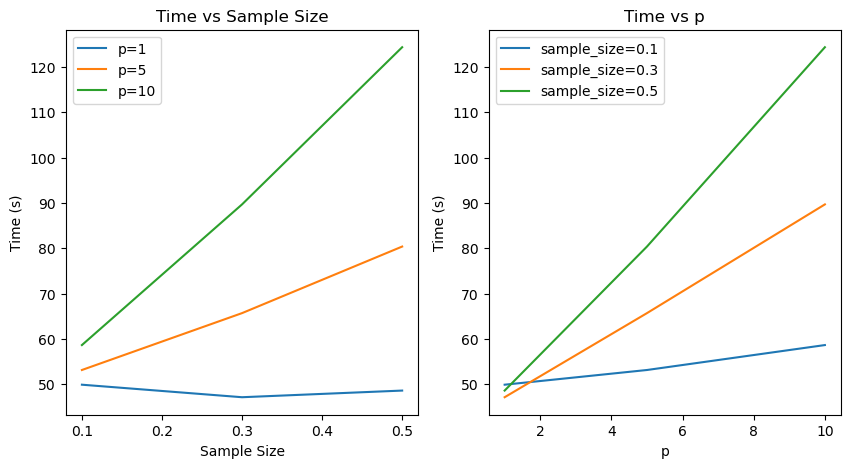

In [12]:
# two plot that show the time taken on the y-axis and the sample size on the x-axis (average over all p)
# The other plot shows the time taken on the y-axis and the p on the x-axis (average over all sample sizes)
times_sample_size = []
times_p = []
for p in ps:
	times_sample_size.append([])
	for sample_size in sample_sizes:
		times_sample_size[-1].append(results[f"{p}_{sample_size}"]['time'])
for sample_size in sample_sizes:
	times_p.append([])
	for p in ps:
		times_p[-1].append(results[f"{p}_{sample_size}"]['time'])

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
for i, p in enumerate(ps):
	ax.plot(sample_sizes, times_sample_size[i], label=f"p={p}")
ax.set_title("Time vs Sample Size")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Time (s)")
ax.legend()

ax = plt.subplot(1, 2, 2)
for i, sample_size in enumerate(sample_sizes):
	ax.plot(ps, times_p[i], label=f"sample_size={sample_size}")
ax.set_title("Time vs p")
ax.set_xlabel("p")
ax.set_ylabel("Time (s)")
ax.legend()

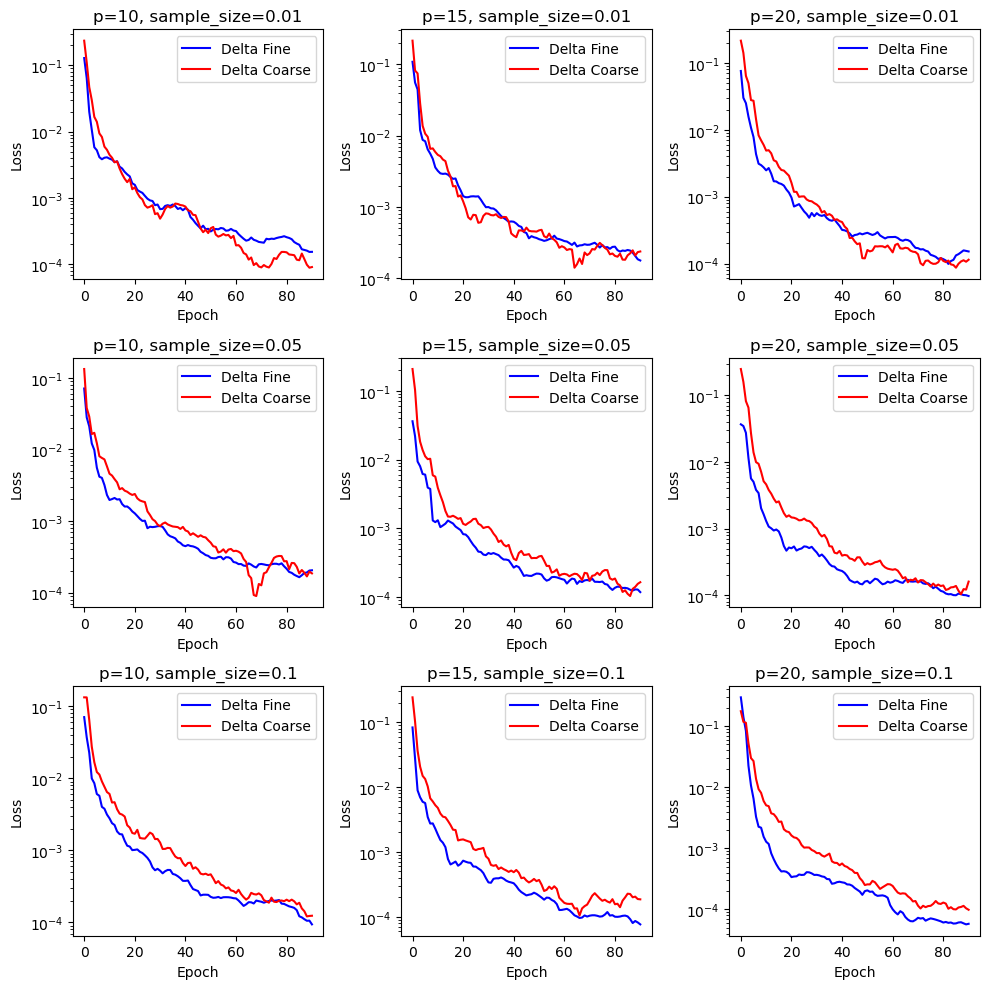

In [35]:
# plot the delta_fine_iter and delta_coarse_iter for each p and sample size
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
		delta_fine_iter = -np.array(results[f"{p}_{sample_size}"]['delta_fine_iter'])
		delta_coarse_iter = -np.array(results[f"{p}_{sample_size}"]['delta_coarse_iter'])

		# smooth the data by taking the average of 10 consecutive values
		delta_fine_iter = np.convolve(delta_fine_iter, np.ones(10) / 10, mode='valid')
		delta_coarse_iter = np.convolve(delta_coarse_iter, np.ones(10) / 10, mode='valid')

		ax.plot(delta_fine_iter, label="Delta Fine", color='blue')
		ax.plot(delta_coarse_iter, label="Delta Coarse", color='red')
		ax.set_title(f"p={p}, sample_size={sample_size}")
		ax.set_xlabel("Epoch")
		ax.set_ylabel("Loss")
		ax.set_yscale('log')
		ax.legend()

fig.tight_layout()
plt.show()

In [22]:
ps = [10, 15, 20]
sample_sizes = [0.01, 0.05, 0.1]
losses = [logistic_loss]

results = {}

for i, loss in enumerate(losses):
	X_train, y_train, X_test, y_test = get_data(-1, 1)
	for p in ps:
		for sample_size in sample_sizes:
			theta, result = two_level(X_train, y_train, loss, p, sample_size, 100)
			train_accuracy = accuracy_func(y_train, X_train, theta).item()
			test_accuracy = accuracy_func(y_test, X_test, theta).item()
			results[f"{p}_{sample_size}"] = result
			print(f"p={p}, sample_size={sample_size}, train_accuracy={train_accuracy}, test_accuracy={test_accuracy}")

p=10, sample_size=0.01, train_accuracy=0.84170001745224, test_accuracy=0.8482000231742859
p=10, sample_size=0.05, train_accuracy=0.8547166585922241, test_accuracy=0.8590999841690063
p=10, sample_size=0.1, train_accuracy=0.8580666780471802, test_accuracy=0.8640999794006348
p=15, sample_size=0.01, train_accuracy=0.8451666831970215, test_accuracy=0.8513000011444092
p=15, sample_size=0.05, train_accuracy=0.8547499775886536, test_accuracy=0.8604999780654907
p=15, sample_size=0.1, train_accuracy=0.8574166893959045, test_accuracy=0.8587999939918518
p=20, sample_size=0.01, train_accuracy=0.8514333367347717, test_accuracy=0.8547000288963318
p=20, sample_size=0.05, train_accuracy=0.8588666915893555, test_accuracy=0.8648999929428101
p=20, sample_size=0.1, train_accuracy=0.8625333309173584, test_accuracy=0.8632000088691711


## Train Accuracy

| sample_size |  p=10 |  p=15 |  p=20                                        |
|-------------|-------|-------|---------------------------------------------|
| **0.01**    | 0.841 | 0.845 | 0.851                                       |
| **0.05**    | 0.854 | 0.854 | 0.859                                       |
| **0.1**     | 0.858 | 0.857 | **<span style="color:green">0.863</span>** |

## Test Accuracy

| sample_size |  p=10 |  p=15 |  p=20                                        |
|-------------|-------|-------|---------------------------------------------|
| **0.01**    | 0.848 | 0.851 | 0.855                                       |
| **0.05**    | 0.859 | 0.860 | **<span style="color:green">0.865</span>**  |
| **0.1**     | 0.864 | 0.859 | 0.863 |


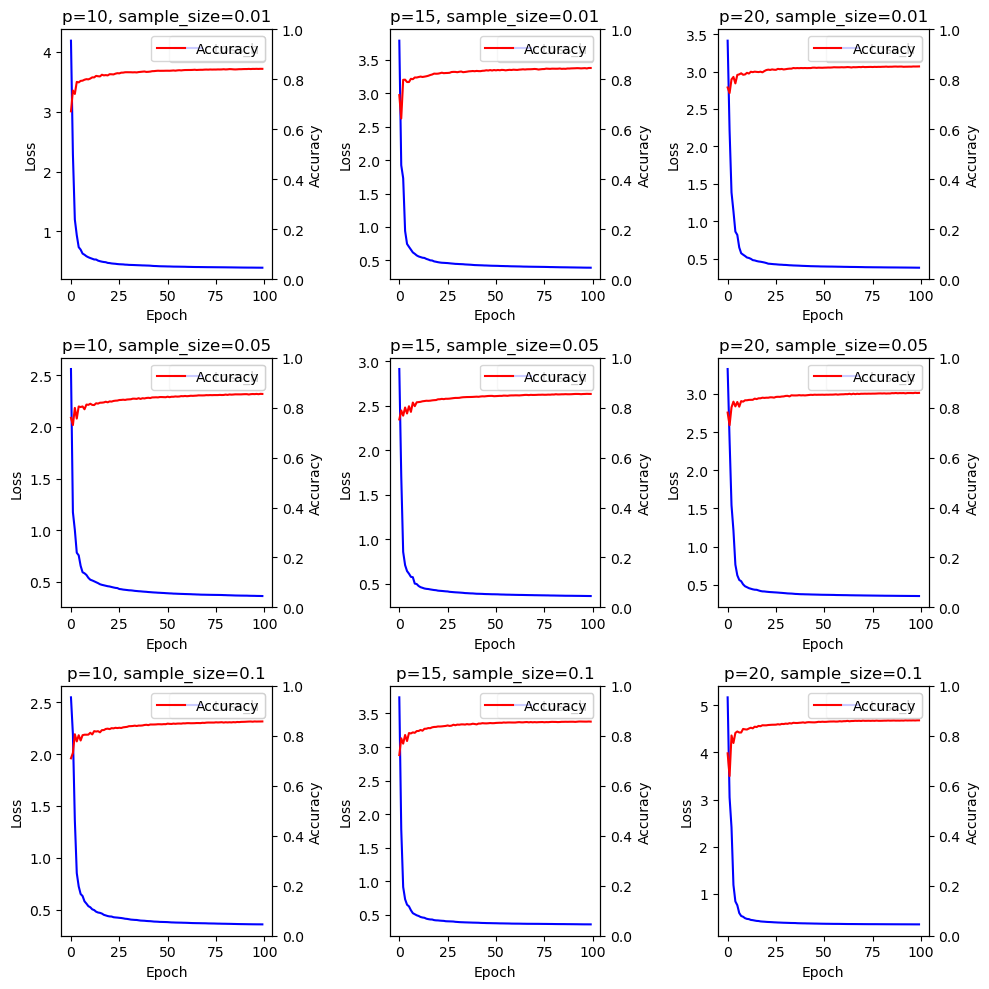

In [34]:
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
		losses_h = results[f"{p}_{sample_size}"]['Losses_h']
		accuracies = results[f"{p}_{sample_size}"]['accuracies']
		ax.plot(losses_h, label="Loss_h", color='blue')
		ax.set_title(f"p={p}, sample_size={sample_size}")
		ax.set_xlabel("Epoch")
		ax.set_ylabel("Loss")
		ax.legend()
		ax2 = ax.twinx()
		ax2.plot(accuracies, color='red', label="Accuracy")
		ax2.set_ylabel("Accuracy")
		ax2.set_ylim(0, 1)
		ax2.legend()

fig.tight_layout()
plt.show()

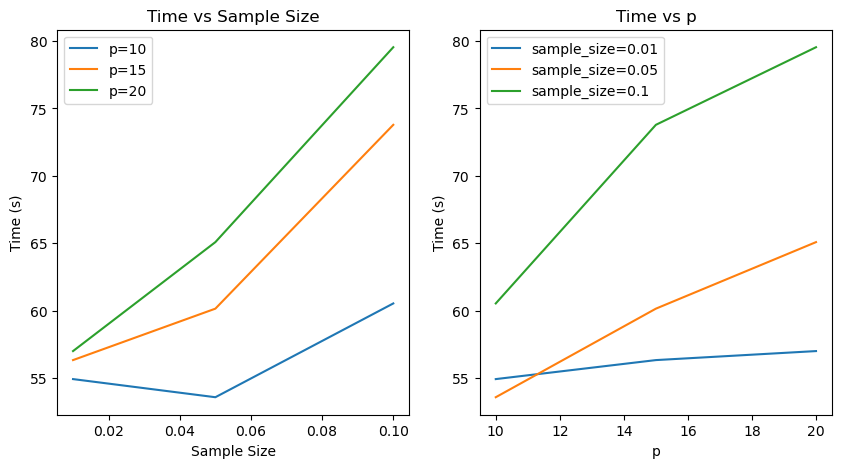

In [27]:
# two plot that show the time taken on the y-axis and the sample size on the x-axis (average over all p)
# The other plot shows the time taken on the y-axis and the p on the x-axis (average over all sample sizes)
times_sample_size = []
times_p = []
for p in ps:
	times_sample_size.append([])
	for sample_size in sample_sizes:
		times_sample_size[-1].append(results[f"{p}_{sample_size}"]['time'])
for sample_size in sample_sizes:
	times_p.append([])
	for p in ps:
		times_p[-1].append(results[f"{p}_{sample_size}"]['time'])

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
for i, p in enumerate(ps):
	ax.plot(sample_sizes, times_sample_size[i], label=f"p={p}")
ax.set_title("Time vs Sample Size")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Time (s)")
ax.legend()

ax = plt.subplot(1, 2, 2)
for i, sample_size in enumerate(sample_sizes):
	ax.plot(ps, times_p[i], label=f"sample_size={sample_size}")
ax.set_title("Time vs p")
ax.set_xlabel("p")
ax.set_ylabel("Time (s)")
ax.legend()

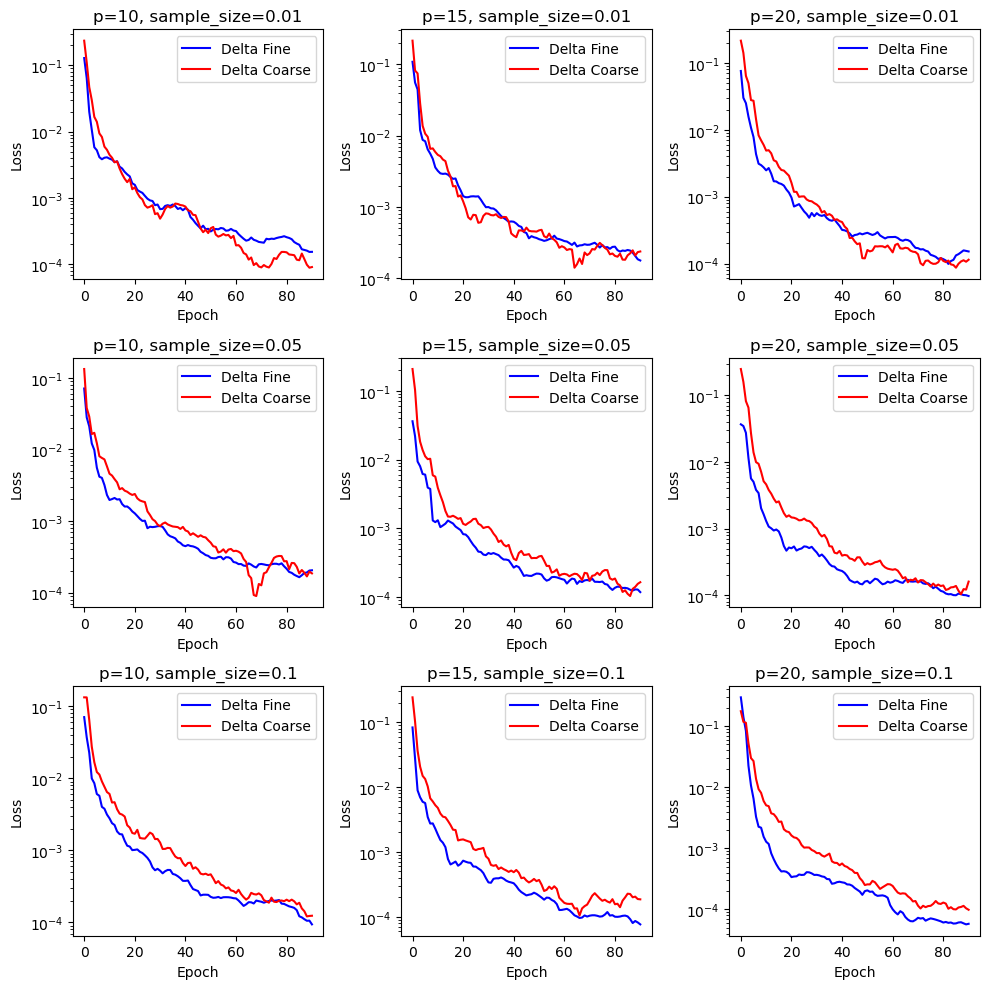

In [33]:
# plot the delta_fine_iter and delta_coarse_iter for each p and sample size
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
		delta_fine_iter = -np.array(results[f"{p}_{sample_size}"]['delta_fine_iter'])
		delta_coarse_iter = -np.array(results[f"{p}_{sample_size}"]['delta_coarse_iter'])

		# smooth the data by taking the average of 10 consecutive values
		delta_fine_iter = np.convolve(delta_fine_iter, np.ones(10) / 10, mode='valid')
		delta_coarse_iter = np.convolve(delta_coarse_iter, np.ones(10) / 10, mode='valid')

		ax.plot(delta_fine_iter, label="Delta Fine", color='blue')
		ax.plot(delta_coarse_iter, label="Delta Coarse", color='red')
		ax.set_title(f"p={p}, sample_size={sample_size}")
		ax.set_xlabel("Epoch")
		ax.set_ylabel("Loss")
		ax.set_yscale('log')
		ax.legend()

fig.tight_layout()
plt.show()

In [42]:
def minibatch_SVRG(X, y, loss_func, p, sample_size, lr, n_epochs, verbose=False):
	theta = torch.randn(X.shape[1], 1, dtype=torch.float32, requires_grad=True)
	Losses = []
	accuracies = []
	time_start = time.time()
	for epoch in range(n_epochs):
		theta.grad = None
		loss = loss_func(y, X, theta)
		Losses.append(loss.item())
		loss.backward()

		G = theta.grad

		theta_k = theta.clone().detach().requires_grad_(True)
		for k in range(p):
			idx = np.random.choice(X.shape[0], int(X.shape[0] * sample_size), replace=False)
			X_k = X[idx]
			y_k = y[idx]
			theta_k.grad = None
			loss_k = loss_func(y_k, X_k, theta_k)
			loss_k.backward()
			grad_k = theta_k.grad

			theta.grad = None
			loss_k2 = loss_func(y_k, X_k, theta)
			loss_k2.backward()
			grad_k2 = theta.grad

			s = grad_k - grad_k2 + G
			with torch.no_grad():
				theta_k -= lr * s
		accuracy = accuracy_func(y, X, theta_k)
		accuracies.append(accuracy.item())
		theta = theta_k.clone().detach().requires_grad_(True)

		if verbose and epoch % 10 == 0:
			print(f'Epoch {epoch}/{n_epochs}, loss {loss.item()}, accuracy {accuracy.item()}')

	result = {
		'Losses': Losses,
		'accuracies': accuracies,
		'time': time.time() - time_start
	}
	return theta, result

In [46]:
ps = [1, 5]
sample_sizes = [0.01, 0.1]
alphas = [0.1, 0.01, 0.001]
losses = [logistic_loss]

results = {}

for i, loss in enumerate(losses):
	X_train, y_train, X_test, y_test = get_data(-1, 1)
	for p in ps:
		for sample_size in sample_sizes:
			for alpha in alphas:
				theta, result = minibatch_SVRG(X_train, y_train, loss, p, sample_size, alpha, 100)
				train_accuracy = accuracy_func(y_train, X_train, theta).item()
				test_accuracy = accuracy_func(y_test, X_test, theta).item()
				results[f"{p}_{sample_size}_{alpha}"] = result
				print(f"p={p}, sample_size={sample_size}, alpha={alpha}, train_accuracy={train_accuracy}, test_accuracy={test_accuracy}")

p=1, sample_size=0.01, alpha=0.1, train_accuracy=0.6556500196456909, test_accuracy=0.6654000282287598
p=1, sample_size=0.01, alpha=0.01, train_accuracy=0.5306000113487244, test_accuracy=0.5331000089645386
p=1, sample_size=0.01, alpha=0.001, train_accuracy=0.504800021648407, test_accuracy=0.4823000133037567
p=1, sample_size=0.1, alpha=0.1, train_accuracy=0.6655499935150146, test_accuracy=0.6753000020980835
p=1, sample_size=0.1, alpha=0.01, train_accuracy=0.4765666723251343, test_accuracy=0.4821999967098236
p=1, sample_size=0.1, alpha=0.001, train_accuracy=0.4762333333492279, test_accuracy=0.47769999504089355
p=5, sample_size=0.01, alpha=0.1, train_accuracy=0.763616681098938, test_accuracy=0.7710999846458435
p=5, sample_size=0.01, alpha=0.01, train_accuracy=0.646133303642273, test_accuracy=0.6596999764442444
p=5, sample_size=0.01, alpha=0.001, train_accuracy=0.5480833053588867, test_accuracy=0.5480999946594238
p=5, sample_size=0.1, alpha=0.1, train_accuracy=0.7649000287055969, test_accur

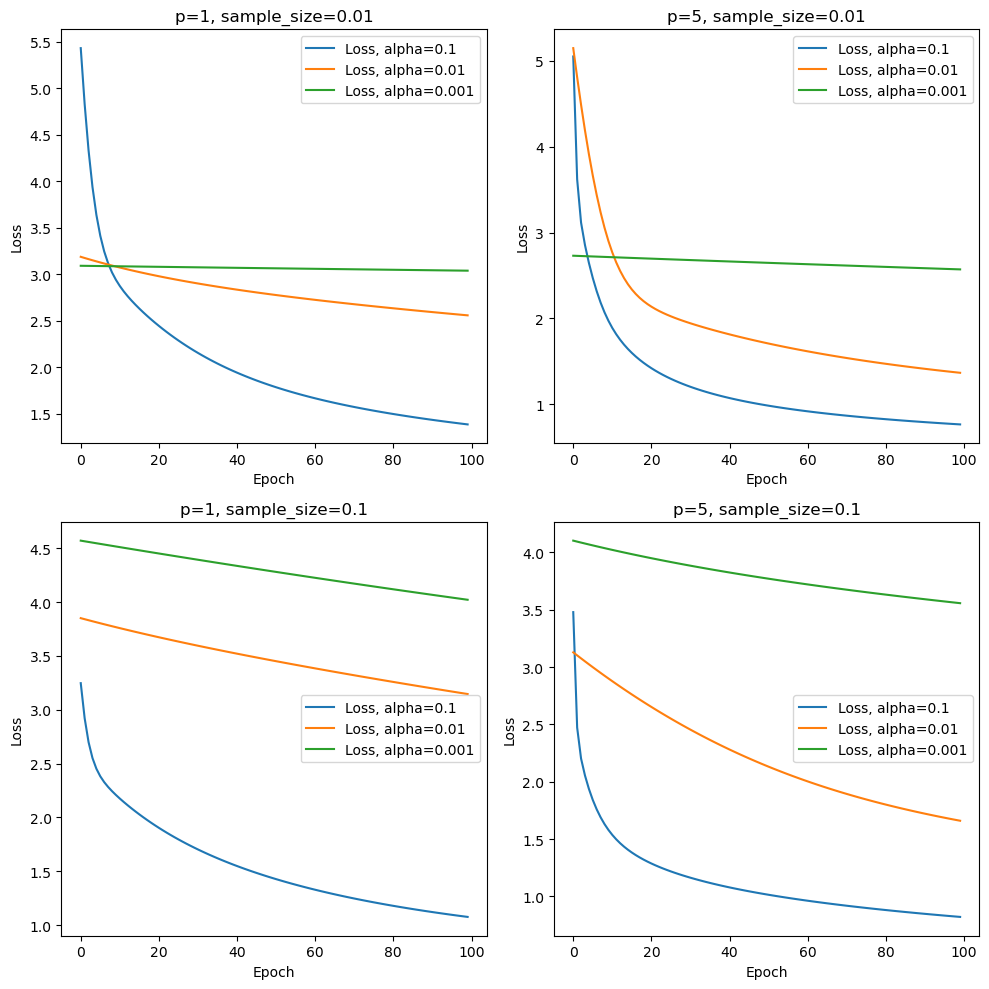

In [50]:
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		for alpha in alphas:
			ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
			losses = results[f"{p}_{sample_size}_{alpha}"]['Losses']
			accuracies = results[f"{p}_{sample_size}_{alpha}"]['accuracies']
			ax.plot(losses, label=f"Loss, alpha={alpha}")
			ax.set_title(f"p={p}, sample_size={sample_size}")
			ax.set_xlabel("Epoch")
			ax.set_ylabel("Loss")
			ax.legend()

fig.tight_layout()
plt.show()

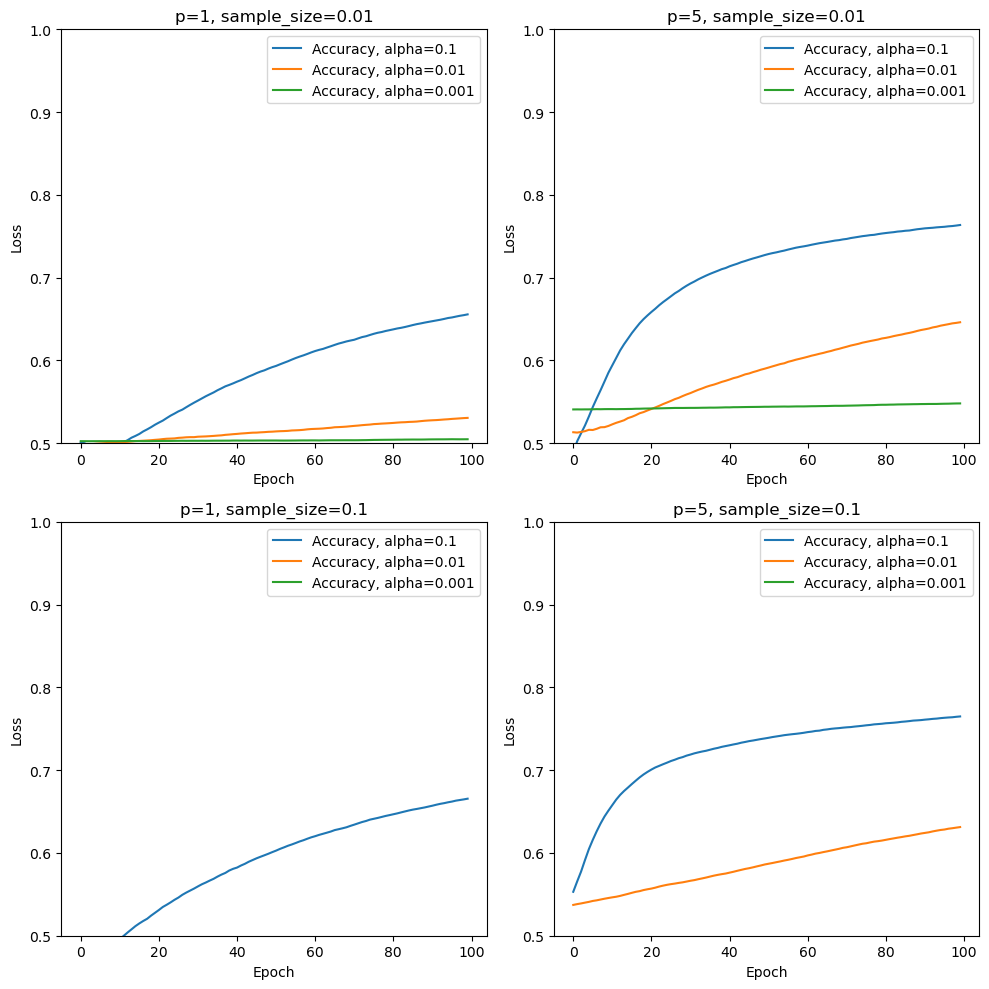

In [54]:
fig = plt.figure(figsize=(10, 10))
for j, p in enumerate(ps):
	for i, sample_size in enumerate(sample_sizes):
		for alpha in alphas:
			ax = plt.subplot(len(ps), len(sample_sizes), i * len(sample_sizes) + j + 1)
			accuracies = results[f"{p}_{sample_size}_{alpha}"]['accuracies']
			ax.set_title(f"p={p}, sample_size={sample_size}")
			ax.plot(accuracies, label=f"Accuracy, alpha={alpha}")
			ax.set_ylabel("Accuracy")
			ax.set_ylim(0.5, 1)
			ax.set_xlabel("Epoch")
			ax.set_ylabel("Loss")
			ax.legend()

fig.tight_layout()
plt.show()

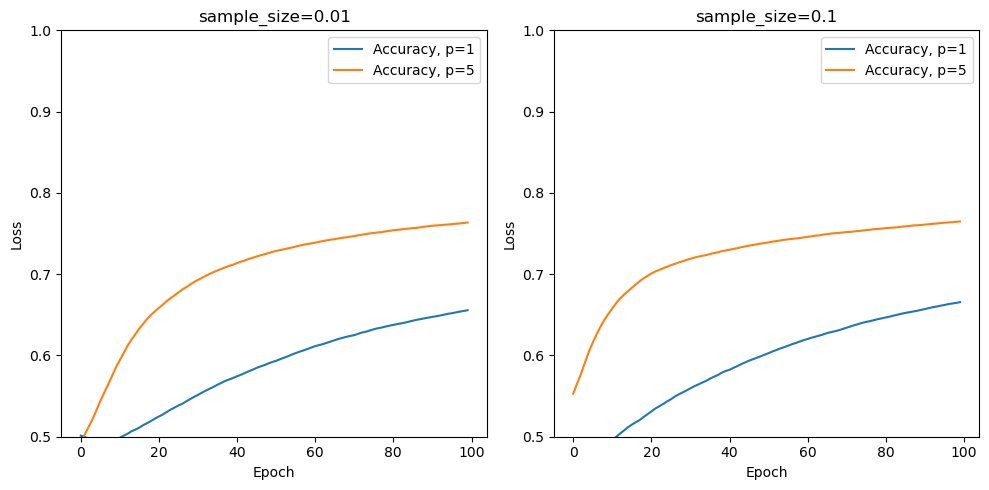

In [60]:
fig = plt.figure(figsize=(10, 5))
alpha = 0.1
for i, sample_size in enumerate(sample_sizes):
	for j, p in enumerate(ps):
			ax = plt.subplot(1, 2, i + 1)
			accuracies = results[f"{p}_{sample_size}_{alpha}"]['accuracies']
			ax.set_title(f"sample_size={sample_size}")
			ax.plot(accuracies, label=f"Accuracy, p={p}")
			ax.set_ylabel("Accuracy")
			ax.set_ylim(0.5, 1)
			ax.set_xlabel("Epoch")
			ax.set_ylabel("Loss")
			ax.legend()

fig.tight_layout()
plt.show()

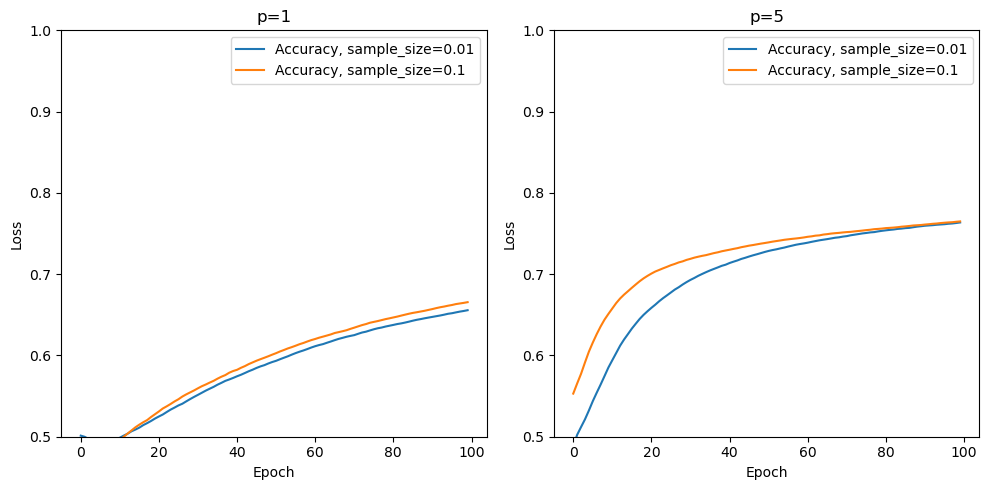

In [61]:
fig = plt.figure(figsize=(10, 5))
alpha = 0.1
for i, sample_size in enumerate(sample_sizes):
	for j, p in enumerate(ps):
			ax = plt.subplot(1, 2, j + 1)
			accuracies = results[f"{p}_{sample_size}_{alpha}"]['accuracies']
			ax.set_title(f"p={p}")
			ax.plot(accuracies, label=f"Accuracy, sample_size={sample_size}")
			ax.set_ylabel("Accuracy")
			ax.set_ylim(0.5, 1)
			ax.set_xlabel("Epoch")
			ax.set_ylabel("Loss")
			ax.legend()

fig.tight_layout()
plt.show()

In [63]:
ps = [5, 10, 15, 20]
sample_sizes = [0.1]
alphas = [0.1, 0.5, 1, 2]
losses = [logistic_loss]

results = {}

for i, loss in enumerate(losses):
	X_train, y_train, X_test, y_test = get_data(-1, 1)
	for p in ps:
		for sample_size in sample_sizes:
			for alpha in alphas:
				theta, result = minibatch_SVRG(X_train, y_train, loss, p, sample_size, alpha, 100)
				train_accuracy = accuracy_func(y_train, X_train, theta).item()
				test_accuracy = accuracy_func(y_test, X_test, theta).item()
				results[f"{p}_{sample_size}_{alpha}"] = result
				print(f"p={p}, sample_size={sample_size}, alpha={alpha}, train_accuracy={train_accuracy}, test_accuracy={test_accuracy}")

p=5, sample_size=0.1, alpha=0.1, train_accuracy=0.7648500204086304, test_accuracy=0.7716000080108643
p=5, sample_size=0.1, alpha=0.5, train_accuracy=0.8147666454315186, test_accuracy=0.8163999915122986
p=5, sample_size=0.1, alpha=1, train_accuracy=0.7649000287055969, test_accuracy=0.771399974822998
p=5, sample_size=0.1, alpha=2, train_accuracy=0.7548666596412659, test_accuracy=0.7473000288009644
p=10, sample_size=0.1, alpha=0.1, train_accuracy=0.7926833629608154, test_accuracy=0.7915999889373779
p=10, sample_size=0.1, alpha=0.5, train_accuracy=0.8409000039100647, test_accuracy=0.8391000032424927
p=10, sample_size=0.1, alpha=1, train_accuracy=0.8474666476249695, test_accuracy=0.848800003528595
p=10, sample_size=0.1, alpha=2, train_accuracy=0.7433833479881287, test_accuracy=0.7465000152587891
p=15, sample_size=0.1, alpha=0.1, train_accuracy=0.7982833385467529, test_accuracy=0.8030999898910522
p=15, sample_size=0.1, alpha=0.5, train_accuracy=0.848966658115387, test_accuracy=0.850099980831

## Train Accuracy

| alpha | p=5  | p=10 | p=15 | p=20                                                |
|-------|------|------|------|-----------------------------------------------------|
| 0.1   | 0.765 | 0.793 | 0.798 | 0.805                                             |
| 0.5   | 0.815 | 0.841 | 0.849 | 0.856                                             |
| 1     | 0.765 | 0.847 | 0.697 | 0.770                                             |
| 2     | 0.755 | 0.743 | 0.866 | **<span style="color:green">0.869</span>**        |

## Test Accuracy

| alpha | p=5  | p=10 | p=15 | p=20                                                |
|-------|------|------|------|-----------------------------------------------------|
| 0.1   | 0.772 | 0.792 | 0.803 | 0.811                                             |
| 0.5   | 0.816 | 0.839 | 0.850 | 0.861                                             |
| 1     | 0.771 | 0.849 | 0.700 | 0.773                                             |
| 2     | 0.747 | 0.747 | 0.868 | **<span style="color:green">0.870</span>**        |


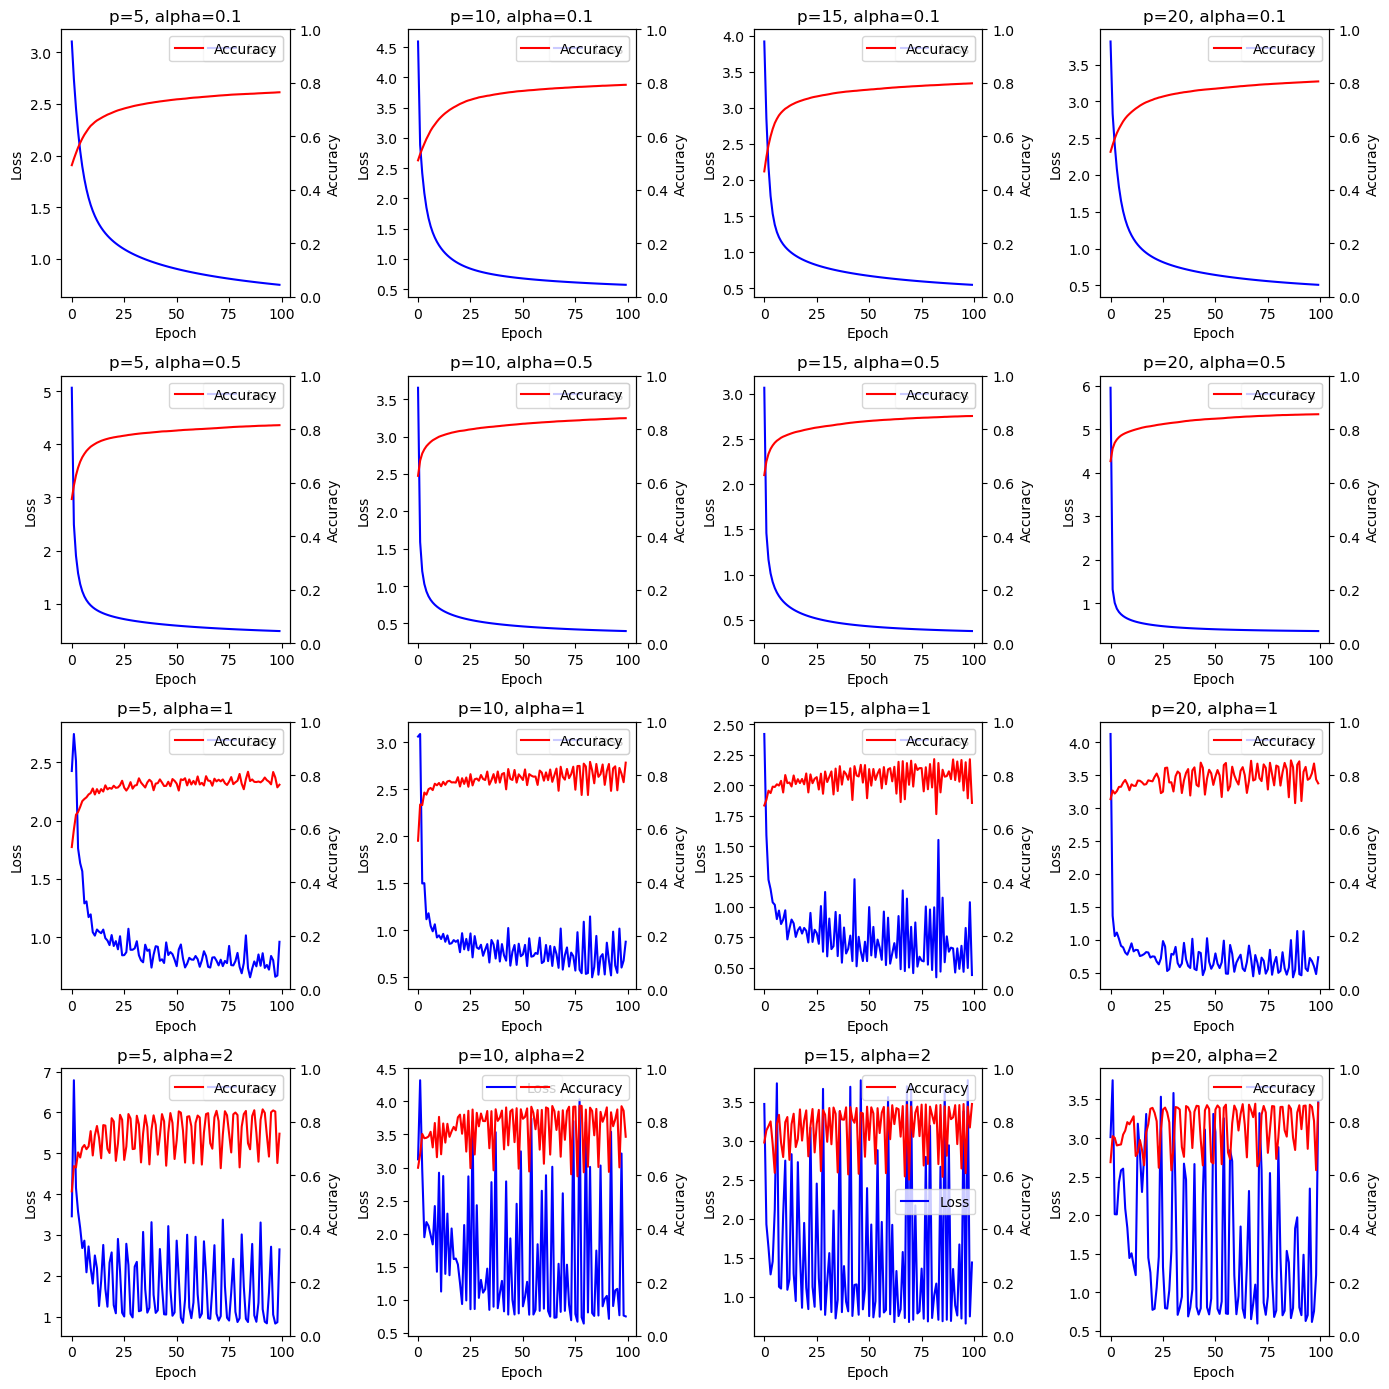

In [65]:
sample_sizes = 0.1
fig = plt.figure(figsize=(14, 14))
for j, p in enumerate(ps):
	for i, alpha in enumerate(alphas):
		ax = plt.subplot(len(ps), len(alphas), i * len(ps) + j + 1)
		losses = results[f"{p}_{sample_size}_{alpha}"]['Losses']
		accuracies = results[f"{p}_{sample_size}_{alpha}"]['accuracies']
		ax.plot(losses, label="Loss", color='blue')
		ax.set_title(f"p={p}, alpha={alpha}")
		ax.set_xlabel("Epoch")
		ax.set_ylabel("Loss")
		ax.legend()
		ax2 = ax.twinx()
		ax2.plot(accuracies, color='red', label="Accuracy")
		ax2.set_ylabel("Accuracy")
		ax2.set_ylim(0, 1)
		ax2.legend()

fig.tight_layout()
plt.show()

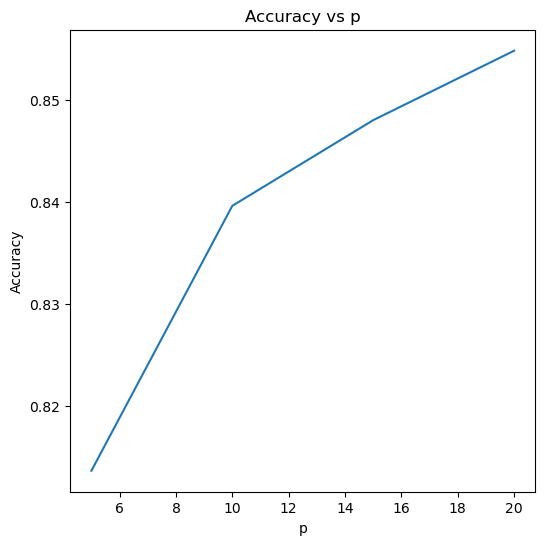

In [69]:
sample_size = 0.1
alpha = 0.5
fig = plt.figure(figsize=(6, 6))
# show the evolution of the accuracy take the average of the 10 last accuracy for each p
accuracies = []
for p in ps:
	accuracies.append(np.mean(results[f"{p}_{sample_size}_{alpha}"]['accuracies'][-10:]))
plt.plot(ps, accuracies)
plt.title("Accuracy vs p")
plt.xlabel("p")
plt.ylabel("Accuracy")
plt.show()

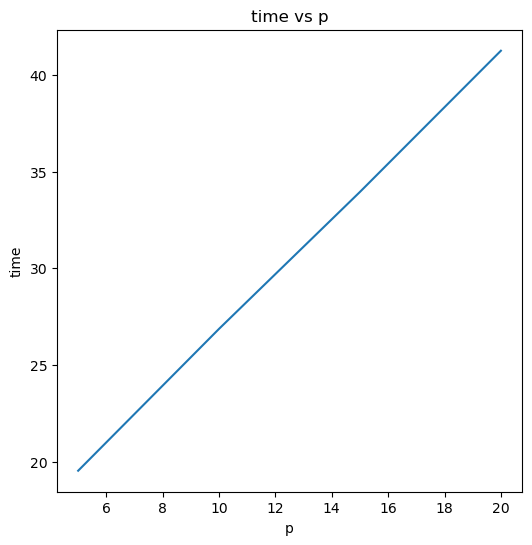

In [71]:
sample_size = 0.1
alpha = 0.5
fig = plt.figure(figsize=(6, 6))
# show the evolution of the accuracy take the average of the 10 last accuracy for each p
times = []
for p in ps:
	times.append(results[f"{p}_{sample_size}_{alpha}"]['time'])
plt.plot(ps, times)
plt.title("time vs p")
plt.xlabel("p")
plt.ylabel("time")
plt.show()

### Let's compare the two models

For the two-level we will take the params:
- $p = 10$
- sample_size $= 0.1$

For the minibatch_SVRG:
- $p = 10$
- sample_size $= 0.1$
- $\alpha = 0.5$

In [72]:
def two_level(X, y, loss_func, p, sample_size, n_epochs, verbose=False):
	theta = torch.randn(X.shape[1], 1, dtype=torch.float32, requires_grad=True)
	X_h = X
	y_h = y
	accuracies = []
	times = []
	for epoch in range(n_epochs):
		time_start = time.time()
		theta.grad = None
		loss_h = loss_func(y_h, X_h, theta)
		loss_h.backward()
		s = -theta.grad
		alpha = line_search(loss_func, X_h, theta, y_h, loss_h, s)
		with torch.no_grad():
			theta += alpha * s

		loss_after_fine = loss_func(y_h, X_h, theta)

		idx = np.random.choice(X_h.shape[0], int(X_h.shape[0] * sample_size), replace=False)
		X_H = X_h[idx]
		y_H = y_h[idx]
		theta_H = theta.clone().detach().requires_grad_(True)
		loss_H = loss_func(y_H, X_H, theta_H)
		theta_H.grad = None
		loss_H.backward()
		s_H = -theta_H.grad
		V_H = -s - s_H

		for _ in range(p):
			loss_H = loss_func(y_H, X_H, theta_H) + V_H.T @ theta_H

			theta_H.grad = None
			loss_H.backward()
			s_H = -theta_H.grad
			alpha = line_search(lambda y, x, w: loss_func(y, x, w) + V_H.T @ w, X_H, theta_H, y_H, loss_H, s_H)
			with torch.no_grad():
				theta_H += alpha * s_H
		s_h = theta_H - theta
		alpha = line_search(loss_func, X_h, theta, y_h, loss_after_fine, s_h)
		with torch.no_grad():
			theta += alpha * s_h
			accuracy = accuracy_func(y_h, X_h, theta)
			accuracies.append(accuracy.item())
			times.append(time.time() - time_start)

		if verbose and epoch % 10 == 0:
			print(f'Epoch {epoch}/{n_epochs}, accuracy {accuracy.item()}')

	result = {
		'accuracies': accuracies,
		'times': times
	}
	return theta, result

In [ ]:
def minibatch_SVRG(X, y, loss_func, p, sample_size, lr, n_epochs, verbose=False):
	theta = torch.randn(X.shape[1], 1, dtype=torch.float32, requires_grad=True)
	accuracies = []
	times = []
	for epoch in range(n_epochs):
		time_start = time.time()
		theta.grad = None
		loss = loss_func(y, X, theta)
		loss.backward()

		G = theta.grad

		theta_k = theta.clone().detach().requires_grad_(True)
		for k in range(p):
			idx = np.random.choice(X.shape[0], int(X.shape[0] * sample_size), replace=False)
			X_k = X[idx]
			y_k = y[idx]
			theta_k.grad = None
			loss_k = loss_func(y_k, X_k, theta_k)
			loss_k.backward()
			grad_k = theta_k.grad

			theta.grad = None
			loss_k2 = loss_func(y_k, X_k, theta)
			loss_k2.backward()
			grad_k2 = theta.grad

			s = grad_k - grad_k2 + G
			with torch.no_grad():
				theta_k -= lr * s
		accuracy = accuracy_func(y, X, theta_k)
		accuracies.append(accuracy.item())
		times.append(time.time() - time_start)
		theta = theta_k.clone().detach().requires_grad_(True)

		if verbose and epoch % 10 == 0:
			print(f'Epoch {epoch}/{n_epochs}, accuracy {accuracy.item()}')

	result = {
		'accuracies': accuracies,
		'times': times
	}
	return theta, result

In [81]:
p = 10
sample_size = 0.1
X_train, y_train, X_test, y_test = get_data(-1, 1)
theta_two_level, result_two_level = two_level(X_train, y_train, logistic_loss, p, sample_size, 200)

In [83]:
p = 10
sample_size = 0.1
alpha = 0.5
X_train, y_train, X_test, y_test = get_data(-1, 1)
theta_SVRG, result_SVRG = minibatch_SVRG(X_train, y_train, logistic_loss, p, sample_size, alpha, 500)

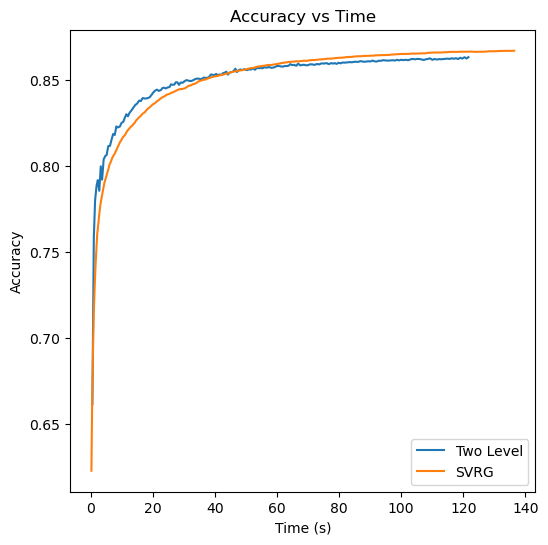

In [84]:
fig = plt.figure(figsize=(6, 6))
# should plot the accuracy in function of the time
plt.plot(np.cumsum(result_two_level['times']), result_two_level['accuracies'], label="Two Level")
plt.plot(np.cumsum(result_SVRG['times']), result_SVRG['accuracies'], label="SVRG")
plt.title("Two level vs SVRG")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### We will now try with different data

In [85]:
def get_data_zero(y_min, y_max):
	train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
	test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

	X_train, y_train = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
	X_test, y_test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))

	X_train = X_train.view(-1, 28*28)
	X_test = X_test.view(-1, 28*28)
	# add a 1 to the end of each sample for the bias term
	X_train = torch.cat((X_train, torch.ones(X_train.shape[0], 1)), dim=1)
	X_test = torch.cat((X_test, torch.ones(X_test.shape[0], 1)), dim=1)

	y_train[y_train == 0] = y_min
	y_train[y_train != 0] = y_max
	y_test[y_test == 0] = y_min
	y_test[y_test != 0] = y_max

	return X_train, y_train, X_test, y_test

In [89]:
p = 10
sample_size = 0.1
X_train, y_train, X_test, y_test = get_data_zero(-1, 1)
theta_two_level, result_two_level = two_level(X_train, y_train, logistic_loss, p, sample_size, 200)

In [90]:
p = 10
sample_size = 0.1
alpha = 0.5
X_train, y_train, X_test, y_test = get_data_zero(-1, 1)
theta_SVRG, result_SVRG = minibatch_SVRG(X_train, y_train, logistic_loss, p, sample_size, alpha, 500)

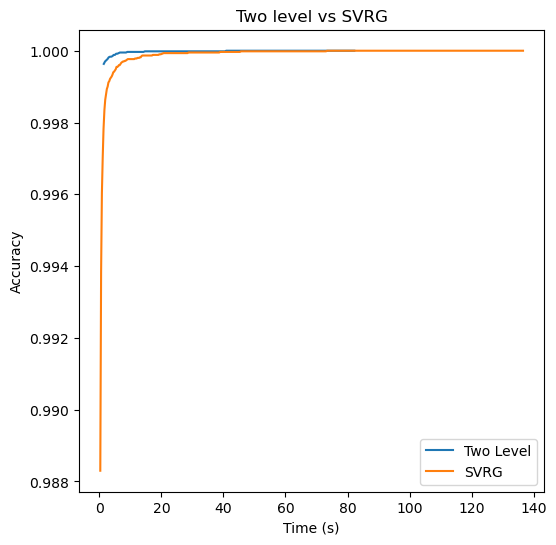

In [91]:
fig = plt.figure(figsize=(6, 6))
# should plot the accuracy in function of the time
plt.plot(np.cumsum(result_two_level['times']), result_two_level['accuracies'], label="Two Level")
plt.plot(np.cumsum(result_SVRG['times']), result_SVRG['accuracies'], label="SVRG")
plt.title("Two level vs SVRG")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [93]:
def get_data_odd(y_min, y_max):
	train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
	test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

	X_train, y_train = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
	X_test, y_test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))

	X_train = X_train.view(-1, 28*28)
	X_test = X_test.view(-1, 28*28)
	# add a 1 to the end of each sample for the bias term
	X_train = torch.cat((X_train, torch.ones(X_train.shape[0], 1)), dim=1)
	X_test = torch.cat((X_test, torch.ones(X_test.shape[0], 1)), dim=1)

	y_train[y_train % 2 != 0] = y_max
	y_train[y_train % 2 == 0] = y_min
	y_test[y_test % 2 != 0] = y_max
	y_test[y_test % 2 == 0] = y_min

	return X_train, y_train, X_test, y_test

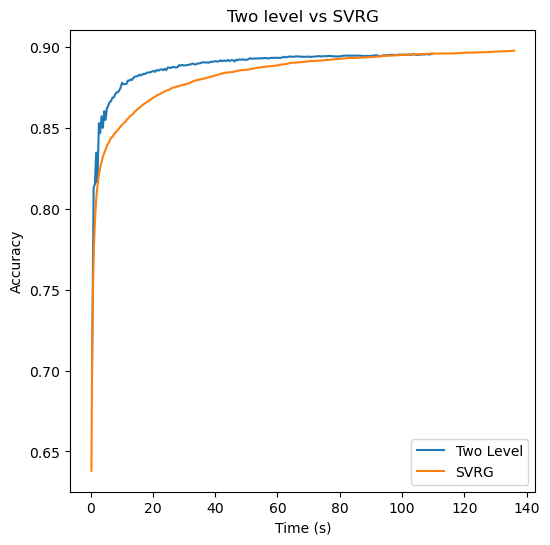

In [94]:
p = 10
sample_size = 0.1
X_train, y_train, X_test, y_test = get_data_odd(-1, 1)
theta_two_level, result_two_level = two_level(X_train, y_train, logistic_loss, p, sample_size, 200)

p = 10
sample_size = 0.1
alpha = 0.5
theta_SVRG, result_SVRG = minibatch_SVRG(X_train, y_train, logistic_loss, p, sample_size, alpha, 500)

fig = plt.figure(figsize=(6, 6))
# should plot the accuracy in function of the time
plt.plot(np.cumsum(result_two_level['times']), result_two_level['accuracies'], label="Two Level")
plt.plot(np.cumsum(result_SVRG['times']), result_SVRG['accuracies'], label="SVRG")
plt.title("Two level vs SVRG")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### VS Adam

In [125]:
def get_data_nn(y_min, y_max):
	train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
	test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

	X_train, y_train = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
	X_test, y_test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))

	X_train = X_train.view(-1, 28*28)
	X_test = X_test.view(-1, 28*28)

	y_train[y_train < 5] = y_min
	y_train[y_train >= 5] = y_max
	y_test[y_test < 5] = y_min
	y_test[y_test >= 5] = y_max

	return X_train, y_train, X_test, y_test

In [126]:
class Model(nn.Module):
	def __init__(self):
		super(Model, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(28*28, 1),
		)

	def forward(self, x):
		return self.model(x)
	
	def predict(self, x):
		return torch.sign(self.model(x))

def logistic_loss_nn(y, y_pred):
	y_pred = y_pred.squeeze()
	loss = torch.log(1 + torch.exp(-y * y_pred)).mean()
	return loss

def accuracy_nn(y, y_pred):
	return (y_pred == y).float().mean()

def adam_model(X, y, sample_size, lr, n_epochs, verbose=False):
	model = Model()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	accuracies = []
	times = []
	dataset = TensorDataset(X, y)
	dataloader = DataLoader(dataset, batch_size=int(X.shape[0] * sample_size), shuffle=True)
	for epoch in range(n_epochs):
		time_start = time.time()
		for X_batch, y_batch in dataloader:
			optimizer.zero_grad()
			y_pred = model(X_batch)
			loss = logistic_loss_nn(y_batch, y_pred)
			loss.backward()
			optimizer.step()
		accuracy = accuracy_nn(y, model.predict(X))
		accuracies.append(accuracy.item())
		times.append(time.time() - time_start)
		if verbose and epoch % 10 == 0:
			print(f'Epoch {epoch}/{n_epochs}, accuracy {accuracy.item()}')

	result = {
		'accuracies': accuracies,
		'times': times
	}
	return model, result

In [ ]:
sample_size = 0.1
alpha = 0.01
X_train, y_train, X_test, y_test = get_data_nn(-1, 1)
model, result_adam = adam_model(X_train, y_train, sample_size, alpha, 11, verbose=True)

Epoch 0/11, accuracy 0.49938347935676575
